In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
customers=pd.read_csv('/content/Customers.csv')
transactions=pd.read_csv('/content/Transactions.csv')

In [5]:
#Merging customer profile and transaction data
customer_transactions=pd.merge(transactions, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

In [6]:
#creating total spend per customer and frequency of product purchas
total_spent=customer_transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spent=total_spent.rename(columns={'TotalValue': 'TotalSpend'})
#creating customer-product purchase matrix
customer_product_matrix=customer_transactions.groupby(['CustomerID', 'ProductID']).size().unstack(fill_value=0)

In [7]:
#merging customer profile and product purchase matrix
customer_profile=pd.merge(customers[['CustomerID', 'Region']], total_spent, on='CustomerID', how='left')
customer_profile=pd.merge(customer_profile, customer_product_matrix, on='CustomerID', how='left')

In [8]:
#encoding region column
customer_profile['Region']=customer_profile['Region'].astype('category').cat.codes

In [9]:
#handling missing values
customer_profile.fillna(0, inplace=True)
#normalization
scaler=StandardScaler()
profile_features=customer_profile.drop(columns=['CustomerID'])
normalized_features=scaler.fit_transform(profile_features)

In [10]:
#applying k-means clustering
n_clusters=5
kmeans=KMeans(n_clusters=n_clusters, random_state=42)
customer_profile['Cluster']=kmeans.fit_predict(normalized_features)
#DB index
db_index=davies_bouldin_score(normalized_features, customer_profile['Cluster'])
print(f"DB Index: {db_index:.4f}")
#silhouette score
silhouette=silhouette_score(normalized_features, customer_profile['Cluster'])
print(f"Silhouette Score: {silhouette:.4f}")

DB Index: 4.0076
Silhouette Score: 0.0374


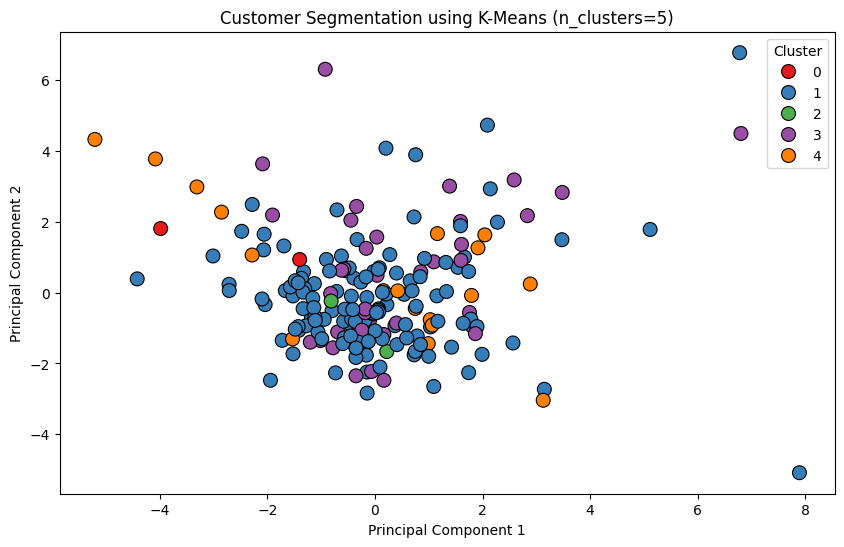

In [11]:
pca=PCA(n_components=2)
principal_components=pca.fit_transform(normalized_features)
#Creating a dataFrame with PCA results and cluster labels
pca_df=pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster']=customer_profile['Cluster']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100, edgecolor='black')
plt.title(f'Customer Segmentation using K-Means (n_clusters={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

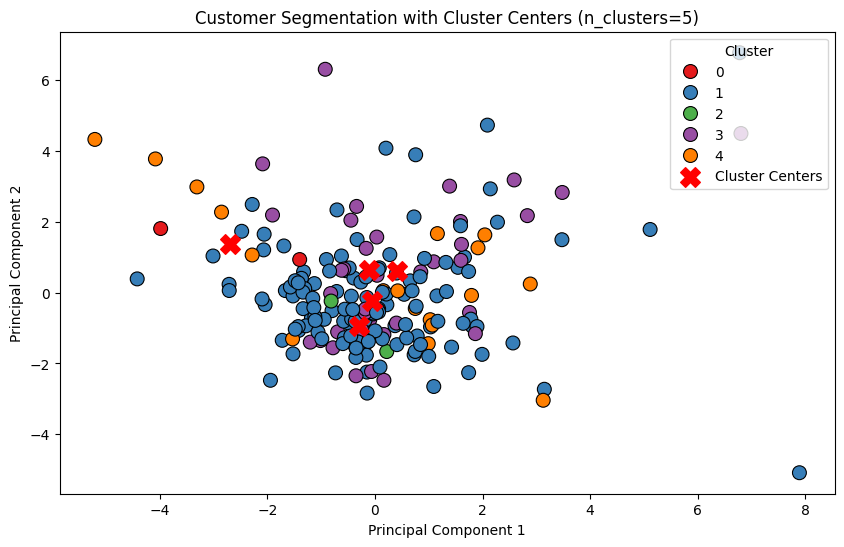

In [12]:
#showing the centres
cluster_centers_pca=pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100, edgecolor='black')
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
plt.title(f'Customer Segmentation with Cluster Centers (n_clusters={n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [13]:
print(f"number of clusters:{n_clusters}")
print(f"DB Index:{db_index:.4f}")
print(f"silhouette score:{silhouette:.4f}")

number of clusters:5
DB Index:4.0076
silhouette score:0.0374
